---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='red'> Student Names: Rohan Crawley, Eros Vincenzo Furina </font></div>
## <div align="center"> <font color='red'> Student numbers: s400045, s4004170 </font></div>
---

# Introduction
## Introduction
We have chosen to tackle project 1 (Classify Images of Colon Cancer) for our assignment.

# Load Data


In [7]:
import zipfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

if not os.path.exists('data_labels_extraData.csv'):
    with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    print('Data extracted successfully')
else:
    print('Data previously extracted')

main_data = pd.read_csv('./data_labels_mainData.csv')
extra_data = pd.read_csv('./data_labels_extraData.csv')
print("Main data : {}, Extra Data: {}".format(main_data.shape, extra_data.shape))

Data previously extracted
Main data : (9896, 6), Extra Data: (10384, 4)


# Cancerous Cell Model

## Prepare Data and Split 

In [8]:
# As there is an isCancerous column for both datasets
# We will join them for this model
data = pd.concat([extra_data, main_data], axis=0, ignore_index=True) # concatenating along rows
data = data.drop(columns=['cellTypeName', 'cellType']) # Drop unnecessary columns
# Split into train, test and val
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape, val_data.shape, test_data.shape))
display(train_data)

Train data : (12168, 4), Val Data: (4056, 4), Test Data: (4056, 4)


,InstanceID,patientID,ImageName,isCancerous
233,18792,63,18792.png,0
17678,3280,46,3280.png,1
2371,6956,71,6956.png,0
5032,2919,80,2919.png,1
9768,21702,92,21702.png,0
...,...,...,...,...
18424,3378,51,3378.png,0
1897,6656,69,6656.png,0
3995,10620,79,10620.png,0
6833,9608,86,9608.png,0


## EDA


Missing Values:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64

Unique Classes:
[0 1]

Class Distribution in Train Data:


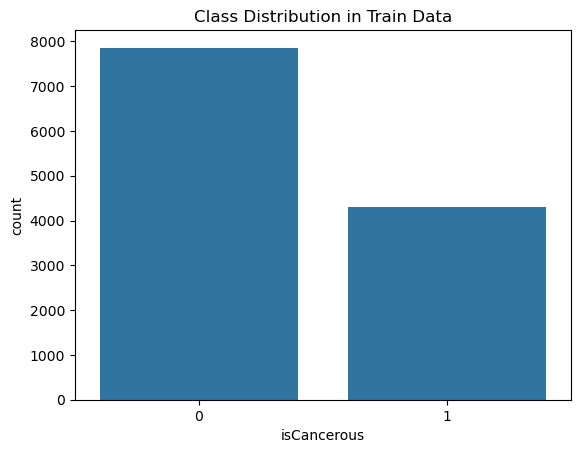

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for null values
print("\nMissing Values:")
print(train_data.isnull().sum())

# Check unique labels
print("\nUnique Classes:")
print(train_data['isCancerous'].unique())

print("\nClass Distribution in Train Data:")
sns.countplot(x='isCancerous', data=train_data)
plt.title('Class Distribution in Train Data')
plt.show()

In [9]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_data.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Set Up Model

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

INPUT_DIM = (27,27,3)
OUTPUT_CLASSES = 1

model = Sequential([
    layers.Input(shape=INPUT_DIM),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(OUTPUT_CLASSES)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 27, 27, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 27, 27, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,569 (381.13 KB)

 Trainable params: 97,569 (381.13 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,  
        class_mode='binary')

epochs = 10
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=0)



Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyError: 'categorical_accuracy'

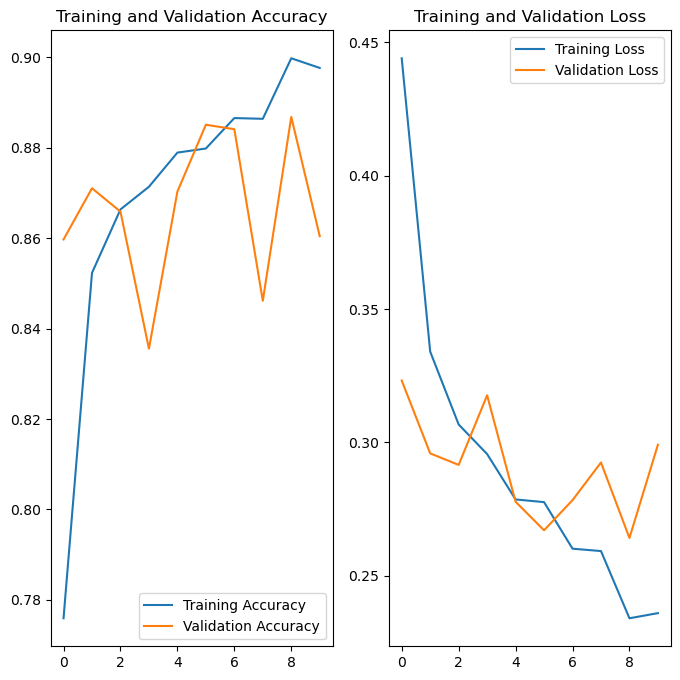

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Plot Results

# Cell Type Model

## Prepare Data and Split

In [1]:
import zipfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

if not os.path.exists('data_labels_extraData.csv'):
    with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    print('Data extracted successfully')
else:
    print('Data previously extracted')

main_data = pd.read_csv('./data_labels_mainData.csv')
extra_data = pd.read_csv('./data_labels_extraData.csv')
print("Main data : {}, Extra Data: {}".format(main_data.shape, extra_data.shape))


data = main_data.drop(columns=['isCancerous']) # Drop unnecessary columns
# Split into train, test and val
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape, val_data.shape, test_data.shape))
display(train_data)

Data previously extracted
Main data : (9896, 6), Extra Data: (10384, 4)
Train data : (5937, 5), Val Data: (1979, 5), Test Data: (1980, 5)


,InstanceID,patientID,ImageName,cellTypeName,cellType
9533,22266,58,22266.png,fibroblast,0
310,18717,4,18717.png,others,3
9480,21202,57,21202.png,inflammatory,1
7073,18114,44,18114.png,fibroblast,0
8977,14070,54,14070.png,epithelial,2
...,...,...,...,...,...
7872,5524,50,5524.png,epithelial,2
5624,11996,31,11996.png,epithelial,2
401,224,5,224.png,inflammatory,1
3394,1071,19,1071.png,others,3


## EDA


Missing Values:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
dtype: int64

Unique Classes:
['fibroblast' 'others' 'inflammatory' 'epithelial']

Class Distribution in Train Data:


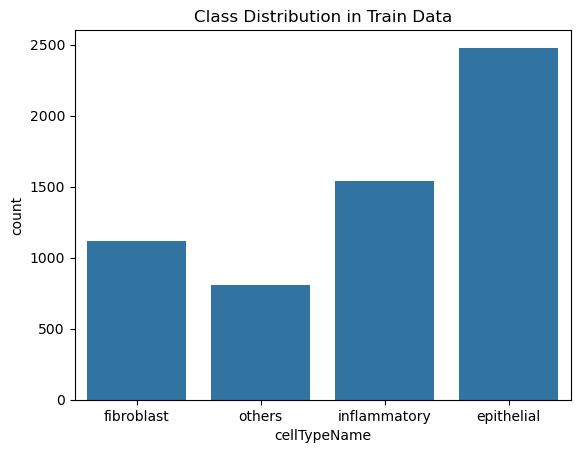

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for null values
print("\nMissing Values:")
print(train_data.isnull().sum())

# Check unique labels
print("\nUnique Classes:")
print(train_data['cellTypeName'].unique())

print("\nClass Distribution in Train Data:")
sns.countplot(x='cellTypeName', data=train_data)
plt.title('Class Distribution in Train Data')
plt.show()

## Create Model

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

INPUT_DIM = (27,27,3)
OUTPUT_CLASSES = 4

model = Sequential([
    layers.Input(shape=INPUT_DIM),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(OUTPUT_CLASSES)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 27, 27, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 27, 27, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,956 (382.64 KB)

 Trainable params: 97,956 (382.64 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


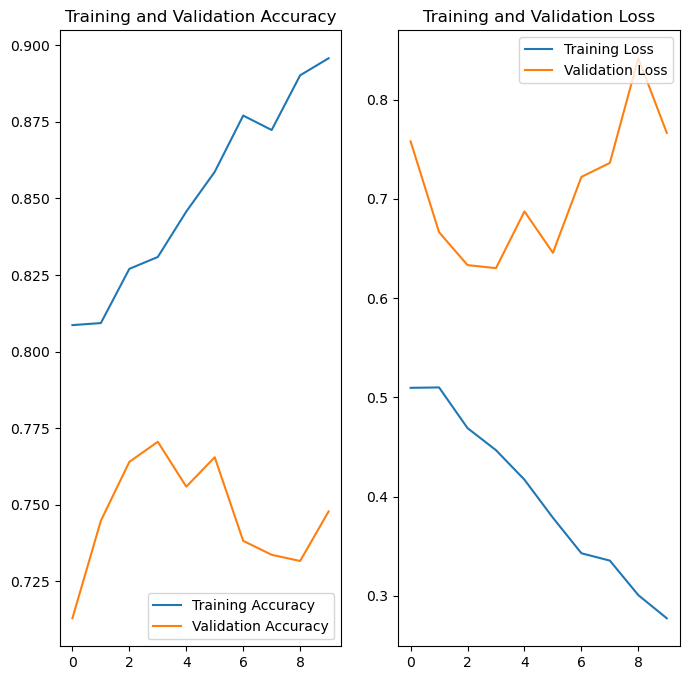

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,  
        class_mode='categorical')

epochs = 10
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=0)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [2]:
from PIL import Image
import os

def find_bad_images(df, image_dir):
    bad = []
    for fname in df['ImageName']:
        fpath = os.path.join(image_dir, fname)
        try:
            with Image.open(fpath) as img:
                img.verify()
        except Exception as e:
            bad.append((fname, str(e)))
    return bad

find_bad_images(data, './patch_images')

[]

# Independant Evaluation
...

# Appendix
...